# Tracing directors' career journeys using time series data
*Julie Nguyen, PhD candidate in Management (Organizational Behavior), McGill University*

Welcome to another chapter of our exploration of how social networks influence the careers of movie directors. Our journey so far has taken us through identifying our sample of directors (`Phase_1_Tracking_Movie_Directors_Career.ipynb`), mapping the collaboration networks within the film industry and calculated the annual social capital of every creative worker (`Phase_2_Constructing_Filmmaker_Network.ipynb`), and predicting the genders of our directors (`Phase_3_Predicting_Director_Gender.ipynb`).

**What are we aiming to do?**

Our next step is to delve into how a director's career unfolds over time. To do this, we're constructing two types of datasets:
- Longitudinal Dataset (`directors_years`): This tracks the career progression of each director year by year from their debut to 2023. This dataset varies in length for each director, ranging from 11 to 21 years, depending on their debut year between 2003 and 2013.
- Cross-sectional Dataset (`directors_cross_sectional`): This dataset summarizes the outcomes of each director's initial 11 years in the industry.

These datasets help us separate the influence of a director's own social capital from that of their collaborators:
- The longitudinal dataset allows us to see how changes in the social capital of collaborators over time might influence a director's career path.
- The cross-sectional dataset focuses on collaborators' social capital when the director first entered the industry and have minimal social capital themselves, thus highlighting the impact of their collaborators.

**How do we do this?**

1. Constructing time series data: Each row in this dataset represents one year in a director's career, from debut to 2023. We include variables such as:
- Annual directorial engagement: Indicates whether a director has directed a film in a given year, showing if they are still active.
- Dropout indicator: Shows if a director has not directed any films in the past 10 years, signaling a possible end to their directing activities.
- Survival analysis variables (`start_time` and `stop_time`): These measure how long directors remain active, focusing on their career phases rather than calendar years.

2. Constructing cross-sectional data: This dataset compiles key aspects of each director's first 11 years post-debut. Variables include:
- Total movies directed: The total number of movies a director made post-debut.
- Career continuation indicator: Whether the director has continued making films during this period.
- Time to Second Movie: The elapsed time between a director’s first and second movie (if exists).

**Looking ahead**

By the end of this notebook, we will have compiled detailed datasets tracking each director's career trajectory, both annually and across their initial decade in the industry. These datasets will serve as the foundation for our upcoming analyses, where we will explore how factors like network connections and gender impact career paths in the film industry.

# Constructing a time series dataset 

In this part of our analysis, we construct the `directors_years` DataFrame. This is a structured timeline that captures the career trajectory of film directors on an annual basis, from their debut year up to the year 2023. Each row in the data represents a single year in the career of a director. Columns include:
- `nconst_director`: A unique identifier for each director.
- `year`: The specific year being considered for that director's career.
- `debut_year`: The year when the director made their debut.

**Source data**

For this task, we use the `directors_full_filmography` dataset, which we created in a previous notebook (`Phase_1_Tracking_Movie_Directors_Career.ipynb`). This dataset catalogs all films directed by 63,169 directors in our study, with each row associating a director (`nconst`) with a movie (`tconst`) they made.

**Defining the study period**

Since our sample of directors made their debut between 2003 and 2013, our career tracking will span from 2003 to 2023. This period is specifically chosen to ensure that we have at least ten years of follow-up data after each director's debut, facilitating a robust long-term analysis of career trajectories.

**Creating a year-by-year framework**

To effectively track each director's activity:
- We first generate all possible combinations of directors and years within our defined range. This exhaustive approach ensures we capture every year of a director's career from their debut to 2023, even if they did not release any movies in some years. 
- Next, for each director we'll exclude years before they began directing. This way, we don't waste time looking at years before they started their directing career.

In [2]:
# Importing necessary libraries for data manipulation and handling
import pandas as pd  # data manipulation
import os  # interacting with the operating system, such as file paths
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
from lifelines import KaplanMeierFitter

# Set the working directory to where the project files are located
os.chdir('/Users/mac/Library/CloudStorage/OneDrive-McGillUniversity/Work/Projects/Gender and brokerage/WomenLeaders_SocialNetworks')

In [3]:
# Load the filmography dataset for movie directors (2003-2023)
directors_full_filmography = pd.read_csv('directors_full_filmography.csv')

# Display the initial rows of the dataset to understand its structure
directors_full_filmography.head()

,tconst,startYear,genres,nconst,firstYear,averageRating,numVotes
0,tt0108549,2004.0,"Comedy,Mystery",nm1131265,2004.0,7.8,34.0
1,tt0108549,2004.0,"Comedy,Mystery",nm1130611,2004.0,7.8,34.0
2,tt0117461,2003.0,"Comedy,Romance",nm0290651,2003.0,6.3,24.0
3,tt0117743,2008.0,"Drama,Romance",nm0404033,2003.0,6.7,64.0
4,tt0118141,2005.0,Drama,nm0000417,2005.0,5.3,950.0


In [4]:
# Convert the 'startYear' column to integer values 
directors_full_filmography['startYear'] = directors_full_filmography['startYear'].astype(int)

# Identify unique directors and define the range of years for our analysis (2003-2023)
# This range is chosen based on the debut years of directors being studied (2003-2013), extending to 2023 for a long-term look at their careers
directors = directors_full_filmography['nconst'].unique()
years = range(2003, 2024) 

# Generate all possible director-year combinations within the specified range
# This creates a framework to examine each director's career on a yearly basis
directors_years = pd.DataFrame([(director, year) for director in directors for year in years], columns=['nconst', 'year'])

# Merge the generated combinations with the original filmography data to include each director's debut year
# This allows us to filter combinations to only include years after each director's debut
directors_years = directors_years.merge(directors_full_filmography[['nconst', 'firstYear']].drop_duplicates(), on='nconst', how='left')

# Filter out rows that represent years before a director's debut, ensuring the dataset only contains relevant director-year pairs
directors_years = directors_years[directors_years['year'] >= directors_years['firstYear']].drop(columns=['firstYear'])
directors_years.rename(columns={'nconst': 'nconst_director'}, inplace=True)

# Identify the debut year for each director
debut_years = directors_years.groupby('nconst_director')['year'].min().reset_index()
debut_years.rename(columns={'year': 'debut_year'}, inplace=True)

# Merge the debut year back into the directors_years dataset to add a debut_year column
directors_years = pd.merge(directors_years, debut_years, on='nconst_director', how='left')

In [5]:
directors_years.head(21)

,nconst_director,year,debut_year
0,nm1131265,2004,2004
1,nm1131265,2005,2004
2,nm1131265,2006,2004
3,nm1131265,2007,2004
4,nm1131265,2008,2004
5,nm1131265,2009,2004
6,nm1131265,2010,2004
7,nm1131265,2011,2004
8,nm1131265,2012,2004
9,nm1131265,2013,2004


Everything is in order! Now we can move on to adding variables indicating career longevity (our outcome variables) to our time series dataset.

# Creating outcome variables for time series data

In this segment of the analysis, we'll create two crucial outcome variables that will help us measure each director's career trajectory and add them to the `directors_years` dataset:

1. Active Engagement (`made_movie`): This binary indicator specifies whether a director released at least one movie in a given year. This provides a direct measure of a director's active engagement in directing during each year of their career. Notably, for a director's debut year, we set this indicator to zero, ensuring that our analysis focuses on activity after their debut.

2. Career Continuity (`dropout`): This variable indicates whether a director potentially dropped out of directing in a given year. We determine this by identifying the last year in which directors released a movie. Directors who have not released any movies since 2013 (the last decade of the observation period) are considered to have potentially dropped out. Conversely, for directors who were active after 2013, we do not specify a dropout year, implying continued involvement in the industry.

As we gear up for survival analysis, let's also create 

3. Relative Career Timing (`start_time` and `stop_time`): These variables are essential for survival analysis, as they allow us to measure the duration of directors' active phases. We calculate these timing variables relative to each director's debut year. This approach allows us to standardize the career timeline across our sample, focusing on the progression and duration of directors' careers without the variability introduced by different debut years.

By the end, we should have a dataset where each row represents a single year in the career of a director, with the following columns:
- `nconst_director`: A unique identifier for each director.
- `year`: The specific year being considered for that director's career.
- `debut_year`: The year when the director made their debut.
- `num_movies`: The number of movies released by the director in that particular year.
- `made_movie`: A binary indicator stating whether the director released any movies in that year (1 if yes, 0 if no).
- `dropoutYear`: A time-invariant variable indicating year the director potentially dropped out, assiged as missing value if the director is still active
- `dropout`: Indicates whether the director is considered to have potentially dropped out of the industry by that year.
- `start_time` and `stop_time`: The relative start and stop times from each director's debut year.

Let's start with creating a binary indicator (`made_movie`) to identify whether a director was active in a given year.

In [5]:
# taking a look at the director filmography data to figure out how to create outcome variables
directors_full_filmography.head()

,tconst,startYear,genres,nconst,firstYear,averageRating,numVotes
0,tt0108549,2004,"Comedy,Mystery",nm1131265,2004.0,7.8,34.0
1,tt0108549,2004,"Comedy,Mystery",nm1130611,2004.0,7.8,34.0
2,tt0117461,2003,"Comedy,Romance",nm0290651,2003.0,6.3,24.0
3,tt0117743,2008,"Drama,Romance",nm0404033,2003.0,6.7,64.0
4,tt0118141,2005,Drama,nm0000417,2005.0,5.3,950.0


In [6]:
# Aggregate the director's filmography data to count unique movies released by each director per year.
movies_released_per_year = directors_full_filmography.groupby(['nconst', 'startYear'])['tconst'].nunique().reset_index()

# Rename columns for clarity: director ID as 'nconst_director', release year as 'year', and number of movies as 'num_movies'.
movies_released_per_year.rename(columns={'nconst': 'nconst_director', 'startYear': 'year', 'tconst': 'num_movies'}, inplace=True)

# Merge the yearly movie release counts with the main dataset to include the number of movies each director released each year.
directors_years = directors_years.merge(movies_released_per_year, on=['nconst_director', 'year'], how='left')

# Replace missing values in 'num_movies' with 0, indicating no movies were released by the director in those years.
directors_years['num_movies'] = directors_years['num_movies'].fillna(0)

# Create a binary indicator 'made_movie' to denote whether the director released any movies in a given year (1 if yes, 0 if no).
directors_years['made_movie'] = (directors_years['num_movies'] > 0).astype(int)

# For the director's debut year, set 'num_movies' and 'made_movie' to 0 so that the variables reflect activity after debut
directors_years.loc[directors_years['year'] == directors_years['debut_year'], ['num_movies', 'made_movie']] = 0

In [7]:
directors_years.head(21)

,nconst_director,year,debut_year,num_movies,made_movie
0,nm1131265,2004,2004,0.0,0
1,nm1131265,2005,2004,0.0,0
2,nm1131265,2006,2004,0.0,0
3,nm1131265,2007,2004,0.0,0
4,nm1131265,2008,2004,0.0,0
5,nm1131265,2009,2004,0.0,0
6,nm1131265,2010,2004,0.0,0
7,nm1131265,2011,2004,0.0,0
8,nm1131265,2012,2004,0.0,0
9,nm1131265,2013,2004,1.0,1


Looks great! Next, we'll move on to identifying career dropout (`dropout`).

In [8]:
# Group by director ID and identify the latest year of movie release to determine the last active year for each director.
last_movie_year = directors_full_filmography.groupby('nconst')['startYear'].max().reset_index()

# Identify directors who haven't made any movies in the last 10 years (between 2014 and 2023)
# These people are considered to have potentially dropped out
dropout_directors = last_movie_year[last_movie_year['startYear'] < 2014].copy()

# Set 'dropoutYear' as the year following their last movie release, marking when they might have left the industry.
dropout_directors['dropoutYear'] = dropout_directors['startYear'] + 1

# Directors who made a movie in 2014 or later are considered still active
# set 'dropoutYear' as NA, indicating they haven't dropped out within the study period
active_directors = last_movie_year[last_movie_year['startYear'] >= 2014].copy()
active_directors['dropoutYear'] = pd.NA

# Combine the dataframes to get a complete view of all directors' potential dropout years.
all_directors_dropout = pd.concat([dropout_directors, active_directors], ignore_index=True).sort_values(by='nconst')

# Display the first and last few rows of the combined dataframe
all_directors_dropout

,nconst,startYear,dropoutYear
43523,nm0000083,2022,<NA>
0,nm0000136,2009,2010
1,nm0000147,2010,2011
43524,nm0000154,2016,<NA>
2,nm0000155,2013,2014
...,...,...,...
63168,nm9986224,2021,<NA>
43519,nm9990558,2009,2010
43520,nm9990640,2007,2008
43521,nm9990734,2009,2010


In [9]:
# Merge the 'dropoutYear' information into the main dataset to indicate the potential dropout year for each director.
directors_years = pd.merge(directors_years, all_directors_dropout[['nconst', 'dropoutYear']],
                           how='left', left_on='nconst_director', right_on='nconst')

# Remove the redundant 'nconst' column after merging.
directors_years.drop(columns='nconst', inplace=True)

# Initialize a 'dropout' column with 0, indicating no dropout event by default.
directors_years['dropout'] = 0

# Update 'dropout' to 1 for years equal to or beyond the 'dropoutYear', marking it as the potential dropout event.
directors_years['dropoutYear'] = pd.to_numeric(directors_years['dropoutYear'], errors='coerce')  # Coerce errors will convert non-numeric to NaN
directors_years['dropout'] = ((directors_years['year'] >= directors_years['dropoutYear'].fillna(9999)).astype(int))

In [10]:
# Display the first few rows
directors_years.head(25)

,nconst_director,year,debut_year,num_movies,made_movie,dropoutYear,dropout
0,nm1131265,2004,2004,0.0,0,NaN,0
1,nm1131265,2005,2004,0.0,0,NaN,0
2,nm1131265,2006,2004,0.0,0,NaN,0
3,nm1131265,2007,2004,0.0,0,NaN,0
4,nm1131265,2008,2004,0.0,0,NaN,0
5,nm1131265,2009,2004,0.0,0,NaN,0
6,nm1131265,2010,2004,0.0,0,NaN,0
7,nm1131265,2011,2004,0.0,0,NaN,0
8,nm1131265,2012,2004,0.0,0,NaN,0
9,nm1131265,2013,2004,1.0,1,NaN,0


Fianlly, we create `start_time` and `stop_time` variables for each director.

In [11]:
# Calculate relative start and stop times based on the director's debut year
directors_years['start_time'] = directors_years['year'] - directors_years['debut_year']
directors_years['stop_time'] = directors_years['start_time'] + 1

In [12]:
directors_years.head(25)

,nconst_director,year,debut_year,num_movies,made_movie,dropoutYear,dropout,start_time,stop_time
0,nm1131265,2004,2004,0.0,0,NaN,0,0,1
1,nm1131265,2005,2004,0.0,0,NaN,0,1,2
2,nm1131265,2006,2004,0.0,0,NaN,0,2,3
3,nm1131265,2007,2004,0.0,0,NaN,0,3,4
4,nm1131265,2008,2004,0.0,0,NaN,0,4,5
5,nm1131265,2009,2004,0.0,0,NaN,0,5,6
6,nm1131265,2010,2004,0.0,0,NaN,0,6,7
7,nm1131265,2011,2004,0.0,0,NaN,0,7,8
8,nm1131265,2012,2004,0.0,0,NaN,0,8,9
9,nm1131265,2013,2004,1.0,1,NaN,0,9,10


In [ ]:
directors_years.to_csv("directors_years.csv", index=False)

# Exploring career longevity in movie directing through visualization

Let's visualize the data to understand the trends in directors' career longevity.

**Cohort Analysis of Annual Dropout Rates**

First, we take a closer look at the annual dropout rates of directors over time. We segment our analysis by the debut year of directors. This allows us to observe how the career trajectories of directors evolve within the context of their entry time into the industry.

In [5]:
directors_data = directors_years

# Filter data to include only years up to the dropout year
filtered_data = directors_data[directors_data['year'] <= directors_data['dropoutYear']]

# Calculate the initial number of directors in each cohort
initial_cohort_size = filtered_data.groupby('debut_year')['nconst_director'].nunique()

# Calculate dropout rates by grouping data by debut year and subsequent years
dropout_by_debut_year = filtered_data.groupby(['debut_year', 'year']).agg(
    total_dropout=('dropout', 'sum')
).reset_index()

# Merge to add initial cohort size to the grouped data
dropout_by_debut_year = dropout_by_debut_year.merge(initial_cohort_size, on='debut_year', how='left')

# Calculate annual dropout rate
dropout_by_debut_year['annual_dropout_rate'] = (dropout_by_debut_year['total_dropout'] / dropout_by_debut_year['nconst_director']) * 100

# Add year since debut for plotting
dropout_by_debut_year['year_since_debut'] = dropout_by_debut_year['year'] - dropout_by_debut_year['debut_year']

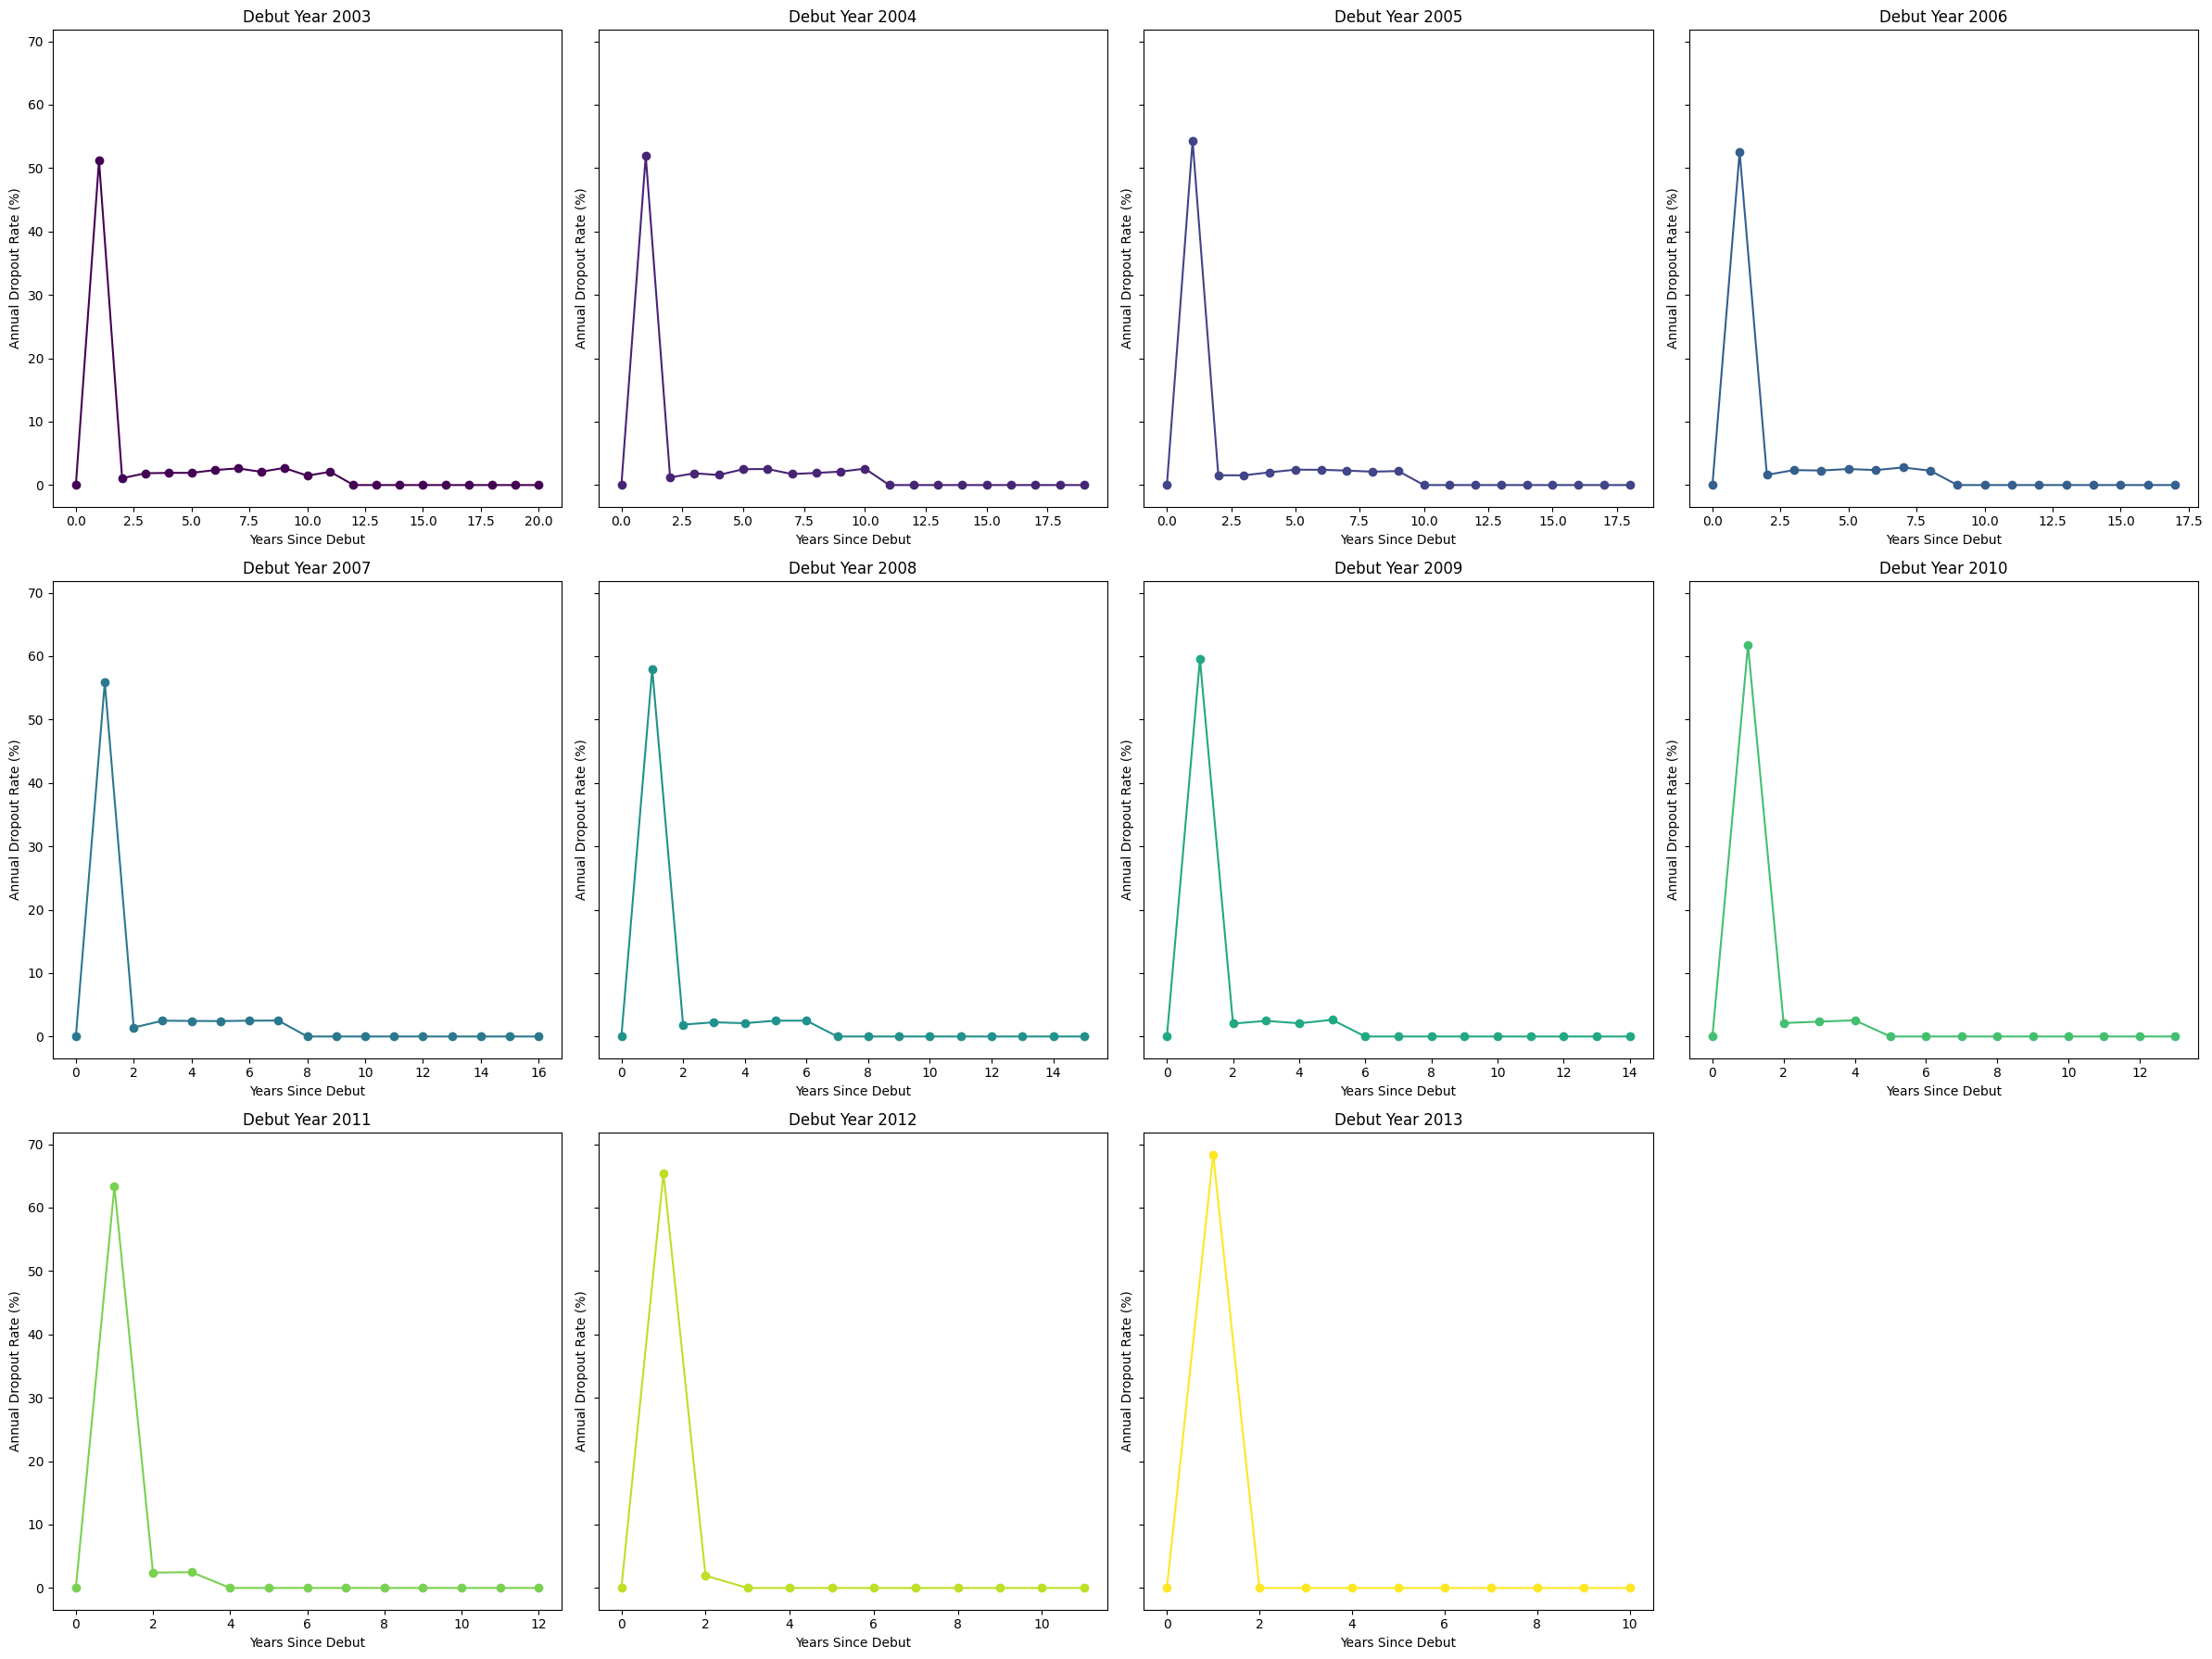

In [9]:
# Count number of unique debut years
unique_debut_years = sorted(dropout_by_debut_year['debut_year'].unique())
n_years = len(unique_debut_years)

# Determine number of rows (each row contains 4 plots)
n_rows = math.ceil(n_years / 4)

# Create a figure with subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=4, figsize=(24, 6 * n_rows), sharey=True)
axes = axes.flatten()  # Flatten to easily iterate

# Define a list of colors
colors = plt.cm.viridis(np.linspace(0, 1, n_years))

# Plotting
for idx, (debut_year, color) in enumerate(zip(unique_debut_years, colors)):
    ax = axes[idx]
    cohort_data = dropout_by_debut_year[dropout_by_debut_year['debut_year'] == debut_year]
    ax.plot(cohort_data['year_since_debut'], cohort_data['annual_dropout_rate'], marker='o', color=color)
    ax.set_title(f'Debut Year {debut_year}')
    ax.set_xlabel('Years Since Debut')
    ax.set_ylabel('Annual Dropout Rate (%)')

# Hide unused axes if any
for i in range(idx + 1, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()


Across all cohorts, there's a noticeable peak in dropout rates in the second year, meaning that most directors never made another movie after their debut. This trend is remarkably consistent regardless of when a director entered the industry, underscoring the competitive nature of the directing career. Following this initial peak, there is a pronounced decline in dropout rates, indicating that directors who overcome early obstacles are more likely to sustain longer careers.

We can see that the dropout rate appears to flatten to 0 in later years for each cohort. However, this observation is influenced by our data's time frame. For newer cohorts, such as those debuting in 2013, we only have 11 years of data. Directors active any time between 2014 and 2023 are considered still active, potentially causing the dropout rate to appear artificially low. The zero dropout rates observed in later years are not definitive. Should more data become available extending past 2023, these rates might adjust but are expected to remain low based on observed trends. 

It is also crucial to note that comparing dropout rates directly between cohorts can be misleading due to different observation periods. Earlier cohorts have had more time potentially to direct a film, which might lower their observed dropout rates.

**Kaplan-Meier survival analysis**

To provide a more comprehensive analysis of career longevity across the entire sample of directors, we utilize the Kaplan-Meier survival analysis model. This method is particularly useful for understanding the time until a director drops out of the industry.

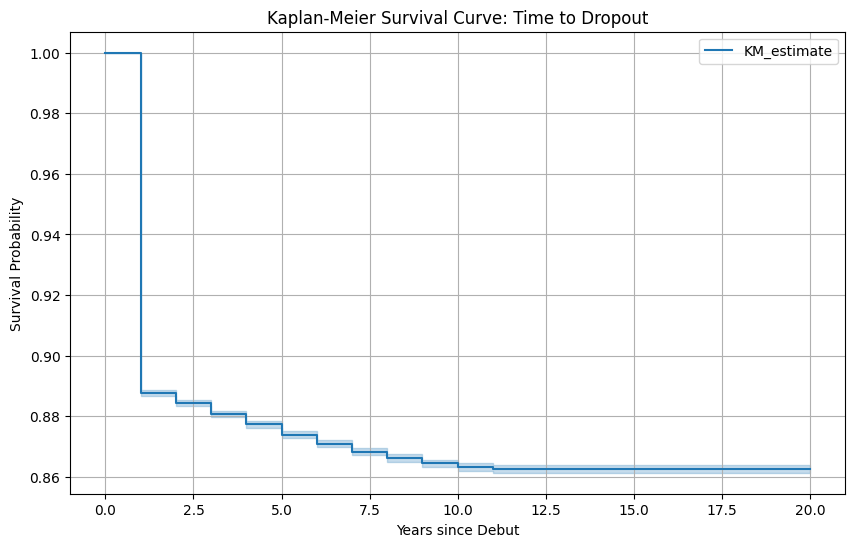

In [20]:
# Setup the Kaplan-Meier fitter
kmf = KaplanMeierFitter()

# Fit the KM model
kmf.fit(durations=filtered_data['start_time'], event_observed=filtered_data['dropout'])

# Plot the Kaplan-Meier survival curve
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
kmf.plot_survival_function()
plt.title('Kaplan-Meier Survival Curve: Time to Dropout')
plt.xlabel('Years since Debut')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()


Here, the Y-Axis represents the probability that a director has not dropped out of the industry. It starts at 1.00 (100%), meaning all directors are active at the time of their debut. The X-Axis indicates the number of years since the directors made their debut. The timeline extends to 20 years in this graph.

There is a sharp drop early in the curve, which suggests a significant proportion of directors drop out after their debut year. The curve declines at a slower rate after the initial drop, eventually beginning to plateau in later years. This plateau suggests that directors who remain active after the initial years are less likely to drop out, likely due to established careers or successful track records.

# Creating cross-sectional dataset

Given the limitations with the different lengths of observation time across cohorts—we need to explore another analytical approach to validate our findings. We will create a cross-sectional dataset capturing detailed career information within the first 11 years of each director's career, starting from their debut. This dataset will allow us to control for different debut year.

With this dataset, we'll investigate the time it takes for a director to release their second movie. It will include the following columns:
- `nconst_director`: A unique identifier for each director. 
- `debut_year`: The year in which a director released their first movie. 
- `time_to_second_movie`: The number of years from the director's debut to the release of their second movie. This is the primary variable of interest for survival analysis, indicating how quickly directors follow up their debut with another film. If a director has not released a second movie within the first 11 years, this is filled with an upper limit value (e.g., 11), representing censored data in survival analysis.
- `event`: A binary indicator coded as 1 if the second movie was made (non-censored), and 0 if the second movie was not made by the end of the study period (censored). This variable is essential for survival analysis, as it helps differentiate between directors who have reached the event of interest (second movie release) and those who have not within the study frame.
- `total_movies`: The total number of movies a director released within the first 11 years of their career.

In [ ]:
# Filter the data to include only the first 11 years of each director's career
filtered_data = directors_years[directors_years['start_time'] <= 10].copy()

# Calculate cumulative movies for each director over time
filtered_data['cumulative_movies'] = filtered_data.groupby('nconst_director')['num_movies'].cumsum()

# Determine the minimum year when cumulative movies reach or exceed 1 
# (meaning their second movie since we set 0 for number of movies in their debut year to focus on analyzing career after debut)
second_movie_time = filtered_data[filtered_data['cumulative_movies'] >= 1].groupby('nconst_director')['start_time'].min()

# Create a DataFrame from the second_movie_time series
second_movie_df = second_movie_time.reset_index()
second_movie_df.columns = ['nconst_director', 'time_to_second_movie']

# Retrieve all director IDs and their debut year
# Merge this with the second_movie_df to include all directors
# Directors without a second movie will have NaN in 'time_to_second_movie'
directors_cross_sectional = filtered_data[['nconst_director', 'debut_year']].drop_duplicates().merge(second_movie_df, on='nconst_director', how='left')

# Create event indicator
directors_cross_sectional['event'] = (~directors_cross_sectional['time_to_second_movie'].isna()).astype(int)  # 1 if second movie made, 0 if not

# Handling the time variable, using the maximum study period for those who didn't make a second movie:
directors_cross_sectional['time_to_second_movie'] = directors_cross_sectional['time_to_second_movie'].fillna(11)

In [ ]:
directors_cross_sectional

,nconst_director,debut_year,time_to_second_movie,event
0,nm1131265,2004,9.0,1
1,nm1130611,2004,11.0,0
2,nm0290651,2003,11.0,0
3,nm0404033,2003,5.0,1
4,nm0000417,2005,2.0,1
...,...,...,...,...
63164,nm4394847,2012,11.0,0
63165,nm10527671,2012,11.0,0
63166,nm10532602,2012,11.0,0
63167,nm4453202,2012,11.0,0


In [ ]:
# Calculate the total number of movies each director made within the first 11 years
total_movies = directors_years[directors_years['start_time'] < 11].groupby('nconst_director')['num_movies'].sum().reset_index()
total_movies.columns = ['nconst_director', 'total_movies']

# Merge this back to the main DataFrame to include all directors
directors_cross_sectional = directors_cross_sectional.merge(total_movies, on='nconst_director', how='left')

In [ ]:
directors_cross_sectional

,nconst_director,debut_year,time_to_second_movie,event,total_movies
0,nm1131265,2004,9.0,1,1.0
1,nm1130611,2004,11.0,0,0.0
2,nm0290651,2003,11.0,0,0.0
3,nm0404033,2003,5.0,1,1.0
4,nm0000417,2005,2.0,1,1.0
...,...,...,...,...,...
63164,nm4394847,2012,11.0,0,0.0
63165,nm10527671,2012,11.0,0,0.0
63166,nm10532602,2012,11.0,0,0.0
63167,nm4453202,2012,11.0,0,0.0


In [ ]:
directors_cross_sectional.to_csv("directors_cross_sectional.csv", index=False)